# Part 1 - Loading Data
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import glob, os, subprocess
from pprint import pprint
import pandas as pd

In [2]:
# for plot
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [3]:
# for PySpark
import findspark
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.session import SparkSession

## 1 The Papers Past Dataset

In [4]:
# set path of raw data
path = r'../data/papers_past'

**Check total dataset directory size:**

In [5]:
print('Total size:', subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8'))

Total size: 33G


**Check dataset files path and size:**

In [6]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0


def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)


# Check the file size
def print_size(flies):
    """
    this function will print the file size of a file list
    """
    i = 1
    for file in files:
        print(i, file,file_size(file))
        i += 1

        
files = glob.glob(path + '/*.txt')
print_size(files)

1 ../data/papers_past/Poverty Bay Herald.txt 1.2 GB
2 ../data/papers_past/Manawatu Standard.txt 133.1 MB
3 ../data/papers_past/Oxford Observer.txt 18.1 MB
4 ../data/papers_past/Tuapeka Times.txt 343.7 MB
5 ../data/papers_past/Mataura Ensign.txt 171.3 MB
6 ../data/papers_past/Bruce Herald.txt 300.1 MB
7 ../data/papers_past/Ohinemuri Gazette.txt 246.6 MB
8 ../data/papers_past/Nelson Examiner and New Zealand Chronicle.txt 223.2 MB
9 ../data/papers_past/NZ Truth.txt 292.3 MB
10 ../data/papers_past/Hawke's Bay Weekly Times.txt 5.1 MB
11 ../data/papers_past/New Zealand Illustrated Magazine.txt 8.8 MB
12 ../data/papers_past/Rodney and Otamatea Times, Waitemata and Kaipara Gazette.txt 125.5 MB
13 ../data/papers_past/Southland Times.txt 531.5 MB
14 ../data/papers_past/Thames Star.txt 710.1 MB
15 ../data/papers_past/Wanganui Herald.txt 791.9 MB
16 ../data/papers_past/Daily Southern Cross.txt 796.9 MB
17 ../data/papers_past/Waiapu Church Gazette.txt 29.6 MB
18 ../data/papers_past/Wellington Indep

**Check total samples/rows/documents of the dataset:**

In [7]:
# list of each file line number
lines = [sum(1 for line in open(f)) for f in files] 

print('Total sample number:', sum(lines))

Total sample number: 16731578


**Visualize the dataset based on the file/publisher:**

In [8]:
# list of each file name
names = [os.path.splitext(os.path.basename(f))[0] for f in files] 
# dictionary of each file path and line number
info = dict(zip(names, lines)) 

# transform dict of dataset files to dataframe for statistic and ploting.
df_info = pd.DataFrame.from_dict(info, orient='index').reset_index()
df_info.columns = ['publisher', 'lines']
df_info = df_info.sort_values('lines', ascending=False).reset_index(drop=True)
df_info.T

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
publisher,Evening Post,Hawera & Normanby Star,Wanganui Chronicle,Otago Daily Times,Marlborough Express,Auckland Star,Poverty Bay Herald,Colonist,Ashburton Guardian,Grey River Argus,...,Waimate Daily Advertiser,New Zealand Illustrated Magazine,Progress,Hawke's Bay Weekly Times,New Zealand Colonist and Port Nicholson Advert...,Kai Tiaki,Fair Play,Waiapu Church Times,New Zealand Advertiser and Bay of Islands Gazette,Albertland Gazette
lines,3007465,807068,804226,747706,711069,674134,643505,638055,603346,574017,...,5037,4201,3216,1690,1650,1630,1180,245,184,112


Text(0.5, 0, 'File/Publisher')

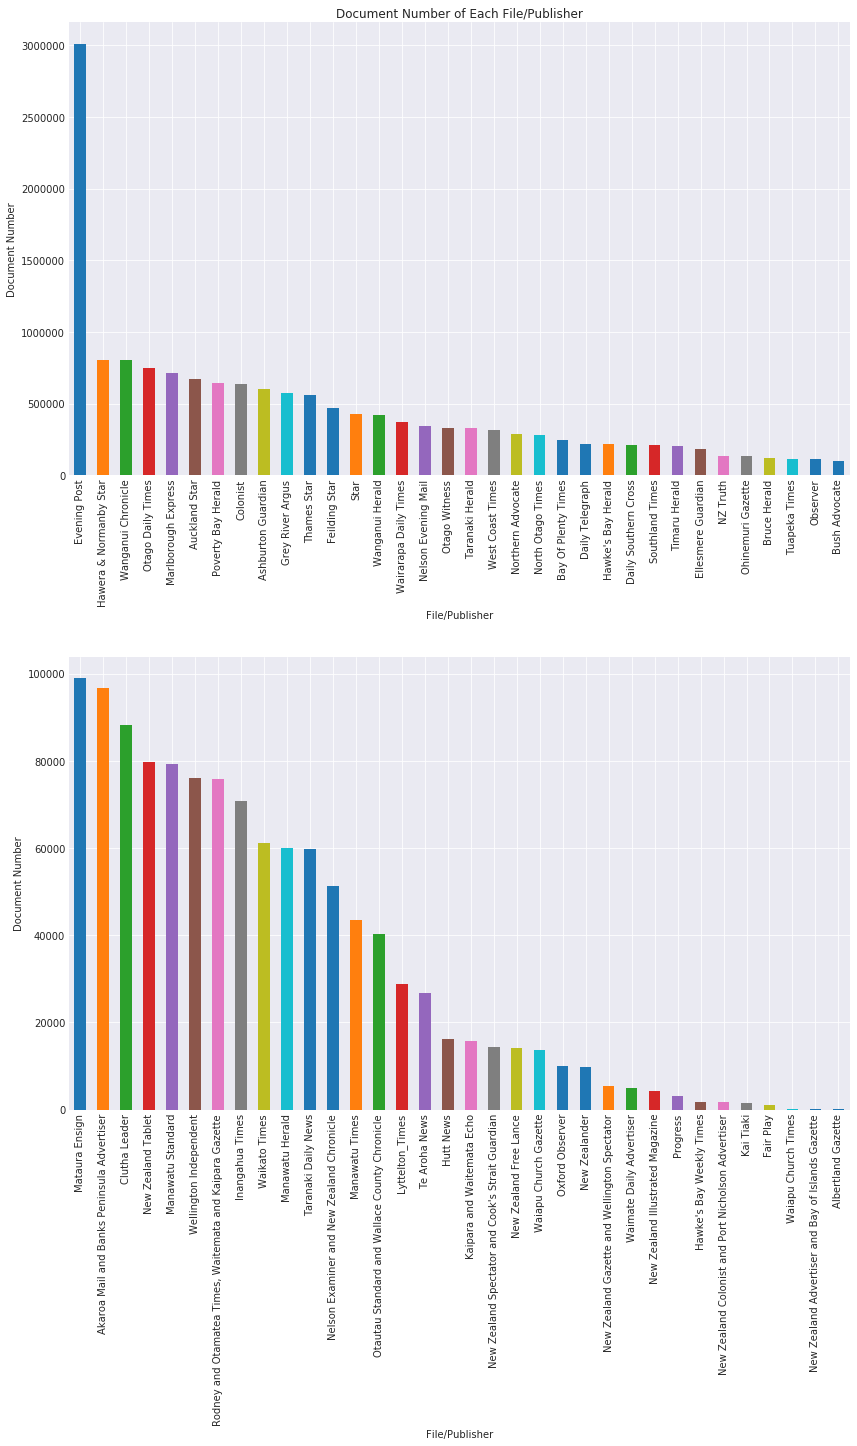

In [9]:
# split to plot better
# index of half dataframe
i = int(df_info.shape[0]/2)
# first half
df_info_1 = df_info.iloc[:i]
# second half
df_info_2 = df_info.iloc[i:]

# plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 20))
fig.subplots_adjust(hspace=0.4)
df_info_1.plot(ax=axes[0], kind='bar', x='publisher', y='lines', legend=False)
df_info_2.plot(ax=axes[1], kind='bar', x='publisher', y='lines', legend=False)
axes[0].set_title('Document Number of Each File/Publisher')
axes[0].set_ylabel('Document Number')
axes[0].set_xlabel('File/Publisher')
axes[1].set_ylabel('Document Number')
axes[1].set_xlabel('File/Publisher')

**The Papers Past dataset has:**
* total 33 GB,
* total 68 files, 
* total 16,731,578 lines(samples), 
* each file contains lines from 3,007,465 (Evening Post) to 112 (Albertland Gazette).

## 2 Loading Dataset With PySpark

**For 33 GB dataset, we chose using PySpark as our data process plateform.**

In [10]:
findspark.init()
# start a Spark context and session
conf = SparkConf()
conf.setAppName('local')
conf.set('spark.driver.cores', 6) # set processor number
conf.set('spark.driver.memory', '62g') # set memory size
conf.set('spark.driver.maxResultSize', '4g')

try:
    sc.stop()
    sc = SparkContext(conf=conf)
except:
    sc = SparkContext(conf=conf)

# passing spark context ot sql module
spark = SparkSession(sc)

# print configurations
pprint(spark.sparkContext._conf.getAll())

# check context
sc

[('spark.driver.port', '32878'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', '192.168.1.207'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1547614337303'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

**Load dataset:**

In [11]:
path = r'../../data/papers_past'

data_schema = StructType([
    StructField('id', IntegerType()),
    StructField('url', StringType()),
    StructField('publisher', StringType()),
    StructField('time', StringType()),
    StructField('title', StringType()),
    StructField('content', StringType())
])

df = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .option("delimiter", "\t")
    .schema(data_schema)
    .load(path)
)

**Print random rows of the loaded dataframe, and check row number of the loaded dataframe:**

In [12]:
df.sample(False, 0.00001).limit(20).show()
print('Shape of dataframe: ({}, {})'.format(df.count(), len(df.columns)))

+--------+--------------------+------------------+--------------------+--------------------+--------------------+
|      id|                 url|         publisher|                time|               title|             content|
+--------+--------------------+------------------+--------------------+--------------------+--------------------+
|15146314|http://api.digita...|Poverty Bay Herald|1912-04-06T00:00:...|ST. MARY'S CHURCH...|ST. MARY'S CHURCH...|
|16721715|http://api.digita...|Poverty Bay Herald|1918-02-18T00:00:...|TOWN EDITION. (Po...|TOWN EDITION.At t...|
| 4786831|http://api.digita...|Poverty Bay Herald|1882-03-10T00:00:...|BERLIN. (Poverty ...|b'BERLIN.March 8....|
| 2969269|http://api.digita...|     Tuapeka Times|1888-08-18T00:00:...|Misunderstood. (T...|Misunderstood.He ...|
| 4814290|http://api.digita...|     Tuapeka Times|1879-06-11T00:00:...|Page 3 Advertisem...|this suggestion H...|
| 2072832|http://api.digita...|      Bruce Herald|1872-12-18T00:00:...|Untitled (Bruce H

---